### DESC Hack Day + Hack week: 2017 SLAC and FNAL Meeting

### Supernova Cosmology Inference with Probabilistic Photometric Redshifts 

Tina Peters, Alex Malz, Anita Bahmanyar, Humna Awan, Kara Ponder

From Confluence: We're planning to hack on a method for making a Hubble diagram using photo-z PDFs rather than point estimators. 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import time
from astropy import cosmology
from astropy.cosmology import FlatLambdaCDM
repoDir= os.getcwd()
os.chdir(os.path.join( repoDir, '..' )) # make sure to run this cell once since this line changes the directory to onr
repoDir= os.getcwd()                    # above everytime it runs and raises an error when reading in data 
from astropy.io import ascii

Create a true catalog of N objects. 

- Know z-dist, type-dist. 
    - Done: N(z) based on Behroozi; SNType distribution from Kara.
- Sample to get z-true and type-true.
    - Same using MC. Seed hard coded. 1000 iterations.
- Calculate mu_s based on z-true, H0-true.

Observed catalogs: prob(z-obs, type-obs, mu-obs | data)



In [2]:
def MC(Nrand, probs): 
    '''
    Parameters
    ----------------------------------------------------------
        Nrand: number of random values
        
        probs: probablities
        
    Output
    ----------------------------------------------------------
        Probabilities after an MC run
    '''
    np.random.seed(10)
    randNs= np.random.random(Nrand)
    
    counts   = np.zeros(len(probs))
    probs    = [0]+list(probs)
    cumProbs = np.cumsum(probs)
    for randN in randNs:   
        for i in np.arange(1,len(probs)):
            if (randN> cumProbs[i-1]) and (randN<=cumProbs[i]):
                counts[i-1]+=1    
    return counts/Nrand

### Loading SN rates
Relative rates for SNeIa and SNeIbc from Kara P. notebook and the actual rates for SNeII from Lluis G. notebook.
Also, changing the column names for easier access.

In [3]:
def change_col_names(data, colnames):
    '''
    Parameters
    ----------------------------------------------------------
        data: data we want to change column names
        colnames: column names we want to be replace 
        
    Output
    ----------------------------------------------------------
        data with updated column names for easier calling
    '''
    data.rename_column('col1', colnames[0])
    data.rename_column('col2', colnames[1])
    data.rename_column('col3', colnames[2])
    data.rename_column('col4', colnames[3])
    #data.write(new_filename, format='ascii')
    return data

In [4]:
# Relative SNe rates for Ia and Ibc
dataDir   = repoDir+'/relative_sne/'                 # data directory for relative SN rates
SNdata    = ascii.read(dataDir+'relative_rates.txt') # data from Kara P.
SNdata    = change_col_names(SNdata, ['redshift','SN_Ia','SN_II','SN_Ibc'])

SNdata_zBin = SNdata['redshift']                      # redshift values from kara P.

# Rates for SNe II 
dataIIDir = repoDir+'/sn_rates/'                      # data directory for SNeII rates
SnII_data = ascii.read(dataIIDir+'SNeII_rates.dat')   # data from Lluis notebook
SnII_data = change_col_names(SnII_data, ['zlluis', 'dn_dz_Horiuchi', 'dn_dz_Cole', 'dn_dz_Madau'])


# Rates for SNeIa
SnIa_data = ascii.read(dataIIDir+'SNeIa_rates.dat')
SnIa_data = change_col_names(SnIa_data, ['zTina', 'dn_dz_Horiuchi', 'dn_dz_Cole', 'dn_dz_Madau'])


os.chdir(repoDir)                                     # change directory back to where the code is

### Interpolation of SNeII and SNeIa data

In [5]:
from scipy import interpolate
# SNeII
snII_rate_Horiuchi = interpolate.interp1d(SnII_data['zlluis'], SnII_data['dn_dz_Horiuchi'])
snII_rate_Cole     = interpolate.interp1d(SnII_data['zlluis'], SnII_data['dn_dz_Cole'])
snII_rate_Madau    = interpolate.interp1d(SnII_data['zlluis'], SnII_data['dn_dz_Madau'])

# SNeIa
snIa_rate_Horiuchi = interpolate.interp1d(SnIa_data['zTina'], SnIa_data['dn_dz_Horiuchi'])
snIa_rate_Cole     = interpolate.interp1d(SnIa_data['zTina'], SnIa_data['dn_dz_Cole'])
snIa_rate_Madau    = interpolate.interp1d(SnIa_data['zTina'], SnIa_data['dn_dz_Madau'])

#### Function for different types of SNeII and SNeIa rates
Three different approaches to computing $\frac{dn}{dz}$: 
- Horiuchi
- Cole
- Madau

In [6]:
def sneii_rates(snType, dnType):
    '''
    Parameters
    ----------------------------------------------------------
        snType: Supernova type (Ia and II for now)
        dnType: dn/dz type. Options are:
                - Horiuchi
                - Cole
                - Madau
        
    Output
    ----------------------------------------------------------
        Interpolated rates so that the redshift values are the 
        same as the redshift values used for SNeIbc relative 
        rates.
        It connects the true value for the first redshift value
        to avoid interpolation range error.
    '''
    
    if snType == "II":
        if dnType == 'Horiuchi':
            return np.insert(snII_rate_Horiuchi(SNdata_zBin[1:]), 0, SnII_data['dn_dz_Horiuchi'][0])
        elif dnType == 'Cole':
            return np.insert(snII_rate_Cole(SNdata_zBin[1:]), 0, SnII_data['dn_dz_Cole'][0])
        elif dnType == 'Madau':
            return np.insert(snII_rate_Madau(SNdata_zBin[1:]), 0, SnII_data['dn_dz_Madau'][0])
        else:
            print "dn/dz type not recognized!"
            
    elif snType == "Ia":
        if dnType == 'Horiuchi':
            return np.insert(snIa_rate_Horiuchi(SNdata_zBin[1:]), 0, SnIa_data['dn_dz_Horiuchi'][0])
        elif dnType == 'Cole':
            return np.insert(snIa_rate_Cole(SNdata_zBin[1:]), 0, SnIa_data['dn_dz_Cole'][0])
        elif dnType == 'Madau':
            return np.insert(snIa_rate_Madau(SNdata_zBin[1:]), 0, SnIa_data['dn_dz_Madau'][0])
        else:
            print "dn/dz type not recognized!"
    else:
        print "supernova type not recognized!"

In [7]:
def probTypes(): # assumes SNData is in the shell 

    #SNdata_Ia  = SNdata['SN_Ia']
    SNdata_Ia  = sneii_rates('Ia', 'Horiuchi') 
    SNdata_Ibc = SNdata['SN_Ibc']
    #SNdata_II  = SNdata['SN_II']
    SNdata_II  = sneii_rates('II', 'Horiuchi') 
    
    probs      = np.zeros(shape=(len(SNdata_Ia), 3))
    for i in range(len(SNdata_Ia)):
        probs[i]= MC(1000, [SNdata_Ia[i], SNdata_Ibc[i], SNdata_II[i]])
    
    return probs

In [8]:
 def probZbin(zBins):  # assume SNdata_zBin is in the shell.
    '''
    Parameters
    ----------------------------------------------------------
        zBinss: redshift bins
        
    Output
    ----------------------------------------------------------
        Redshift probability distribution from Kara P. N(z)
        notebook.
        Note: 
            Star formation history = cosmic star formation rate
            (From Behroozi et al (2013))
        normNz returns cosmic SFR(z)
    '''
    
    def unnormNz(zBins):
        z0 = 1.243
        A  = -0.997
        B  = 0.241
        C  = 0.180
        return C/(10.**(A*(zBins-z0)) + 10.**(B*(zBins-z0)))*(1./0.7)
    
    def normNz(zBins):
        unnorm       = unnormNz(zBins)
        normConstant = np.dot(zBins,unnorm)
        return unnorm/normConstant
        
    probs = MC(1000, normNz(zBins[1:]))
    return probs #[probs, zBins]

In [9]:
def mu(H0, z, Om0=0.3): 
    '''
    Parameters
    ----------------------------------------------------------
        H0 : current Hubble constant
        z  : redshift
        Om0: current omega matter
        
    Output
    ----------------------------------------------------------
        distance modulus(mu) assuming a flat universe
    '''
    cosmo = FlatLambdaCDM(H0=H0, Om0=0.3)
    dL    = cosmo.luminosity_distance(z)  
    
    return 5*np.log10(dL.value)+25

### Scramble the data to create a mock 'observed' catalog.

$P(\mu, z, T|\ell, f, \theta^*, \Phi^*)=  P(\ell, f| \mu, z, T) P(\mu|\theta^*) P(z, T|\Phi^*)$

We take $\theta^*= H_0$, so $ P(\mu|\theta^*)= 1$

Here we dont have a joint probability distribution of redshift and SN type. Instead, we have

$P(z, T|\Phi^*)= P(z|T,N(z)) \ P(T)$

where $F(T)$ is based on SN fractions from Kara.

In [10]:
def hyper_probTypes(zBins): # assumed prob dist of SN types as a function of z.
    '''
    Parameters
    ----------------------------------------------------------
        zBins: redshift bins
        
    Output
    ----------------------------------------------------------
        Probabilities returned from MC on SNdata file 
        (This is similar to probTypes() but with each type
         having the same probability)
    '''
    # assume SNdata_zBin is in the shell.
    totEntries = len(zBins)
    # assigning the same probability to each type
    SNdata_Ia  = np.zeros(totEntries) + 1/3.
    SNdata_Ibc = np.zeros(totEntries) + 1/3.
    SNdata_II  = np.zeros(totEntries) + 1/3.
    
    probs      = np.zeros(shape=(len(SNdata_Ia), 3))
    for i in range(len(SNdata_Ia)):
        probs[i] = MC(1000, [SNdata_Ia[i], SNdata_Ibc[i], SNdata_II[i]])
    
    return probs

In [11]:
def hyper_probZbin(zBins):  # assume SNdata_zBin is in the shell.
    '''
    Parameters
    ----------------------------------------------------------
        zBinss: redshift bins
        
    Output
    ----------------------------------------------------------
        Redshift probability distribution (not from Kara P.)
        
    '''
    def normNz(zBins):
        unnorm       = np.zeros(len(zBins))+1. # same N in each zBin
        normConstant = np.dot(zBins,unnorm)
        return unnorm/normConstant

    probs= MC(1000, normNz(zBins))
    return probs

In [12]:
def find_true_z(NTotObjs, zType):
    '''
    Parameters
    ----------------------------------------------------------
        NTotObjs: total number of SNe
        zType   : how we want the redshifts to be
                  'kara' for redshifts based on SFR(z)
                  'same' for SNe with the same p(z)
        
    Output
    ----------------------------------------------------------
        True redshift of SNe and their redshift indices
    '''
    zTrue    = np.zeros(NTotObjs)
    trueType = np.zeros(NTotObjs)

    zBins    = SNdata_zBin
    
    if zType == 'kara': 
        probZ    = probZbin(zBins)
        probZ    = [0]+list(probZ)
        cumProbZ = np.cumsum(probZ)
    elif zType == 'same':
        probZ    = hyper_probZbin(zBins)
        probZ    = [0]+list(probZ)
        cumProbZ = np.cumsum(probZ)
        
    randNs   = np.random.random(NTotObjs)
    zInd     = np.zeros(NTotObjs)   # lower z-bin index. easiest to use to get probT later

    for i in range(NTotObjs):
        for j in np.arange(1,len(cumProbZ)):
            if (randNs[i]> cumProbZ[j-1]) and (randNs[i]<=cumProbZ[j]):
                zInd[i]= j-1
                zTrue[i]= np.random.uniform(low=zBins[j-1], high=zBins[j]) #np.mean([zBins[j-1],zBins[j]])
    return zInd, zTrue


In [13]:
def find_true_type(NTotObjs, zTrue, zInd, zType):
    '''
    Parameters
    ----------------------------------------------------------
        NTotObjs: total number of SNe
        zTrue : true redshift from find_true_z(NTotObjs) func
        Zind  : true z indices from find_true_z(NTotObjs) func
        
    Output
    ----------------------------------------------------------
        True types of SNe 
    '''
    # find true types given true redshifts
    randNs   = np.random.random(NTotObjs)
    trueType = np.zeros(NTotObjs)
    
    if zType == 'kara': 
        probT  = probTypes()
    
    elif zType == 'same':
        probT  = hyper_probTypes(zTrue)
    
    for i in range(len(zTrue)):
        probTz    = [0]+list(probT[np.int(zInd[i])])
        cumProbTz = np.cumsum(probTz)

        for j in np.arange(1,len(cumProbTz)):
            if (randNs[i]> cumProbTz[j-1]) and (randNs[i]<=cumProbTz[j]):
                trueType[i]= j
                
    return trueType

### Example 1 - $\mu$ vs $z$ for different $H_0$ values

In [14]:
NTotObjs    = 500
zInd, zTrue = find_true_z(NTotObjs, 'kara')
trueType    = find_true_type(NTotObjs, zTrue, zInd, 'kara')

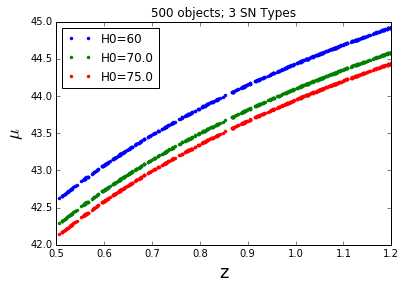

In [15]:
H0s         = [60, 70., 75.]
fontsize    = 18
for H0 in H0s:
    muTrue = mu(H0= H0, z= zTrue, Om0=0.3)
    plt.plot(zTrue, muTrue, '.', label= 'H0=%s'%H0)
plt.title('%s objects; 3 SN Types'%NTotObjs)
plt.xlabel('z', fontsize= fontsize)
plt.ylabel('$\mu$', fontsize= fontsize)
plt.legend(loc= "best")

### Example 2 - $\mu$ vs $z$ for different SN types

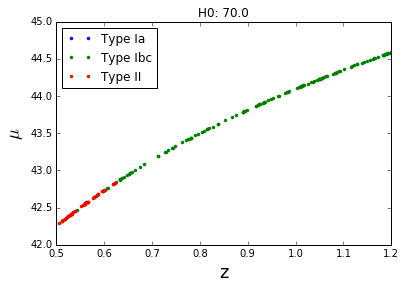

In [16]:
H0     = 70.
muTrue = mu(H0= H0, z= zTrue, Om0=0.3)
labels = {1: 'Type Ia', 2: 'Type Ibc', 3: 'Type II'}
for typeNum in [1., 2., 3.]:
    ind = np.where(trueType==typeNum)[0]
    plt.plot(zTrue[ind], muTrue[ind], '.', label= '%s'%labels[typeNum])

plt.title('H0: %s'%H0)
plt.xlabel('z', fontsize= fontsize)
plt.ylabel('$\mu$', fontsize= fontsize)
plt.legend(loc= "best")

### Example 3 - $P(z)$ vs $z$ using same probabilities for each SN type

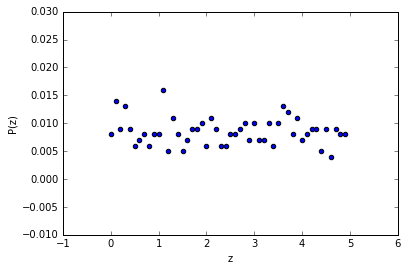

In [17]:
zBins = np.arange(0,5, 0.1)
plt.scatter(zBins, hyper_probZbin(zBins))
plt.xlabel('z')
plt.ylabel('P(z)')

$P(\ell, f| \mu, z, T)= MVN(\ell, f| \mu, z, \sigma_{\mu z})D(T)$

where MVN is Multivariate gaussian dist, D is a discrete probability distribution.

In [18]:
from scipy.stats import multivariate_normal

In [19]:
zInd, zPrime = find_true_z(NTotObjs, 'same')
uPrime       = mu(H0, zPrime, Om0=0.3)

In [20]:
cov = np.diag(np.array([1,1]))
MVN= multivariate_normal(mean=[np.mean(uPrime), np.mean(zPrime)], cov= cov) #.pdf(4)

In [21]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]

To do: add a function to sample give probs, etc.